# Bayesian Curve Fitting

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

from scipy.stats import norm

plt.rcParams.update({"font.size": 20})

True function

$$
\hat f(x) = e^{-2x} \cos(3 \pi x)
$$

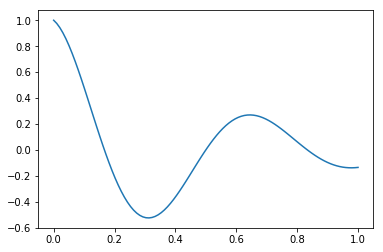

In [2]:
# true function
π = np.pi
fhat = lambda x: np.exp(-2 * x) * np.cos(3 * π * x)

xplt = np.linspace(0, 1, 100)
yplt = fhat(xplt)
plt.plot(xplt, yplt)

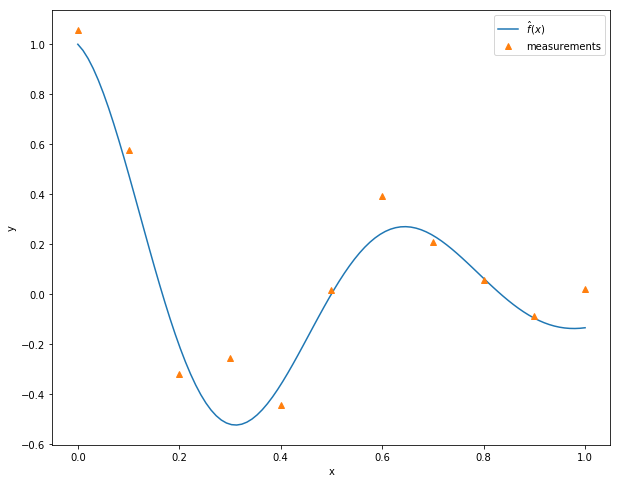

In [3]:
# measurements
γ = 0.1
rnd.seed(2)


x_meas = 0.1 * np.arange(0, 11)
η = rnd.normal(loc=γ, scale=γ, size=np.shape(x_meas))
y = fhat(x_meas) + η

# plot
fig = plt.figure(figsize=(10, 8))
plt.plot(xplt, yplt, label="$\\hat f(x)$")
plt.plot(x_meas, y, "^", label="measurements")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("problem.pdf")

### Prior

Let $\mathcal C$ be the Green's function for the following problem:

$$
\mathcal L u = \frac{d^2 u}{dx^2} = f(x) \quad x \in \left[0, 1\right] \quad 
u'(0) = u'(1) = 0
$$

Then KLSE gives 

$$
\frac{d^2 \phi_k}{dx^2} - \frac{1}{\lambda_k} \phi_k = 0 \quad \phi_k'(0) = \phi_k'(1) = 0
$$

The only valid solutions are for $\frac{1}{\lambda_k} = -\beta_k^2$, giving

$$
\phi_k(x) = a \sin(\beta_k x) + b \cos(\beta_k x)
$$

Then the boundary conditions

$$
\phi_k'(x) = \beta_k(a \cos(\beta_k x) - b \sin(\beta_k x))
$$

$$
\phi_k'(0) = a \beta_k = 0 \implies a = 0
$$

And the other condition

$$
\phi_k'(1) = -b \beta_k \sin \beta_k = 0
$$

So either the solution is exactly zero, or $\beta_k = k \pi$ for $k \in \mathbb N$

Using the Sturm-Liouville inner product, then the normalization gives 

$$
\phi_k(x) = \sqrt 2 \cos (k \pi x) \quad \lambda_k = \frac{1}{k^2 \pi^2} \quad k \in \mathbb N
$$

Any constant value is also a solution for $\beta_k = 0$, however this will be included in the 
mean for the prior.  Using KLSE we have 

$$
X(x) = m_0(x) + \sum_{k=1}^\infty \xi_k \phi_k(x) \sim \mathcal N(m_0, \mathcal C_0) \quad 
\xi_k \sim \mathcal N\left(0, \frac{1}{k \pi}\right)
$$

Finally, our measurements are located at 10 equally spaced grid points.  Beyond $k = 10$ there will be 
no impact on the probability, therefore we will truncate the sum at $K = 10$.  Next we will
let $m_0(x) \equiv 0$ for simplicity

In [4]:
# eigenfunctions/values
ϕ = lambda x, k: np.sqrt(2) * np.cos(k * π * x)
K = 10
λ_vals = 1 / np.power(np.arange(1, K+1) * π, 2)


In [5]:
# helper function for probability of acceptance
def build_f(x, ξ):
    Kmat, Xmat = np.meshgrid(np.arange(1, len(ξ)+1), x)
    ϕmat = ϕ(Xmat, Kmat)
    f_vals = ϕmat @ ξ
    return f_vals

Φ = lambda f, y, γ: -1 / (2 * γ**2) * np.power(np.linalg.norm(y - f), 2)

In [6]:
# sampling
rnd.seed(10)

# performance designation
β = 0.5

# sampling
Nsamples = 100000
Ξ = np.zeros((Nsamples, K))

# previous Φ for compuational savings
Φ_prev = Φ(build_f(x_meas, Ξ[0, :]), y, γ)

# MCMC loop
for i in range(Nsamples-1):
    # new sample for ξ
    ζ = rnd.normal(loc=0, scale=np.sqrt(λ_vals))
    ξ_prop = np.sqrt(1 - β ** 2) * (Ξ[i, :] - Ξ[0, :]) + β * ζ
    
    # proposed f and Φ
    f_prop = build_f(x_meas, ξ_prop)
    Φ_prop = Φ(f_prop, y, γ)
    
    # probability of acceptance
    p_accept = np.min([1, np.exp(Φ_prop - Φ_prev)])
    α = rnd.uniform(low=0, high=1)
    
    # accept / reject
    if α <= p_accept:
        Ξ[i+1, :] = ξ_prop
        Φ_prev = Φ_prop
    else:
        Ξ[i+1, :] = Ξ[i, :]

In [7]:
# results
ξ_mean = np.mean(Ξ, axis=0)
ξ_std = np.std(Ξ, axis=0)

# sampling resulting distribution
rnd.seed(17)

f_samples = np.zeros((Nsamples, len(xplt)))
for i in range(Nsamples):
    ξ = rnd.normal(ξ_mean, ξ_std)
    f_samples[i, :] = build_f(xplt, ξ)

# pointwise mean and standard deviation
f_mean = np.mean(f_samples, axis=0)
f_std = np.std(f_samples, axis=0)

# confidence bound on f(x)
f_ci = norm.interval(0.95, loc=f_mean, scale=f_std)
upper = f_ci[1]
lower = f_ci[0]

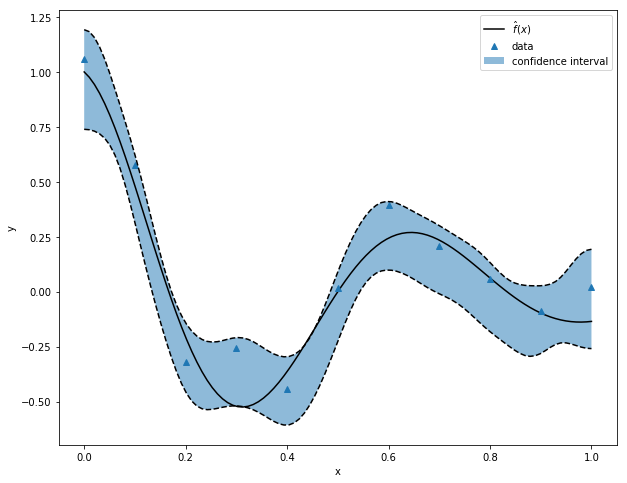

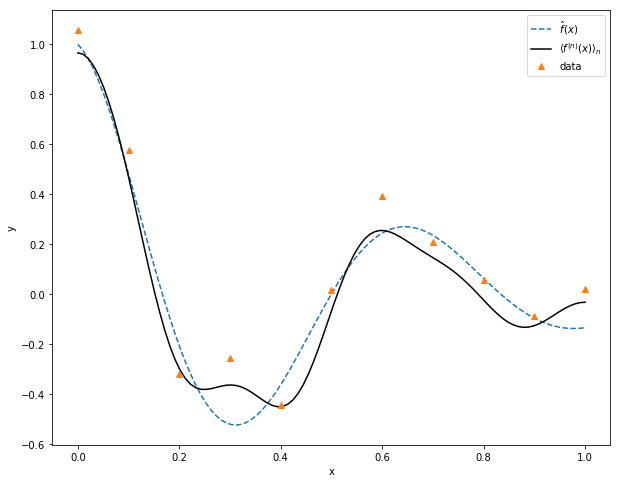

In [8]:
# plotting

# confidence bound
fig = plt.figure(figsize=(10, 8))
plt.plot(xplt, yplt, "k", label="$\\hat f(x)$")
plt.plot(x_meas, y, "^", label="data")
plt.plot(xplt, upper, "k--")
plt.plot(xplt, lower, "k--")
plt.fill_between(xplt, lower, upper, alpha=0.5, label="confidence interval")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("interval-result.pdf")
plt.show()

# mean of samples of f(x)
fig = plt.figure(figsize=(10, 8))
plt.plot(xplt, yplt, "--", label="$\\hat f(x)$")
plt.plot(xplt, f_mean, "k", label="$\\langle f^{(n)}(x)\\rangle_n$")
plt.plot(x_meas, y, "^", label="data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("mean-fit.pdf")
plt.show()

In [9]:
print(np.max(np.abs(f_mean - yplt)))
print(np.linalg.norm(f_mean - yplt))
print(np.linalg.norm(f_mean - yplt, 1))

0.15887781613940227
0.8201442760009211
6.9628286818336145


## Example of Gaussian Process

### Diagonalizing a Covariance Kernel

$$
\mathcal C f = \int_{-1}^1 c(x, y) f(y) \, dy
$$

Let $\mathbf x$ be the mesh values we evaluate on.  Then let $\mathbf f = f(\mathbf x)$.  
Can we build a matrix $A$ such that 

$$
\mathcal Cf(\mathbf x) = A f(\mathbf x)
$$

Consider $\left[\mathcal C f(\mathbf x)\right]_i$, then 

$$
\left[\mathcal C f(\mathbf x)\right]_i = \sum_{j=1}^N A_{ij} \left[f(\mathbf x)\right]_j
$$

Indicating $A_{ij} = c(x_i, x_j)$.

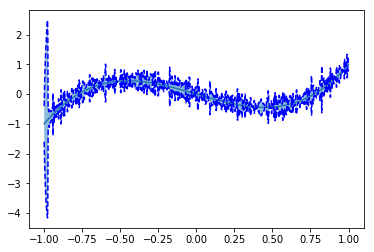

In [19]:
# mean
μ = lambda x: 1 / 2 * (5 * np.power(x, 3) - 3 * x)

# covariance kernel
c = lambda x, y: 1 / (2 * π) * np.exp(-np.power(np.abs(x - y), 2) / 2)

# finite dimensional version
xvals = np.linspace(-1, 1, 1000)
mean = μ(xvals)
X, Y = np.meshgrid(xvals, xvals)

# covariance matrix
C = c(X, Y)

# diagonalize
λ, V = np.linalg.eig(C)

# sample the finite dimensional distribution
ns = 10000

# fd version of KLSE
Ξ_samples = rnd.normal(loc=np.zeros(len(λ)), scale=np.sqrt(np.abs(λ)), size=[ns, len(λ)])
f_samples = mean + Ξ_samples @ np.real(V)

fs_mean = np.mean(f_samples, axis=0)
fs_std = np.std(f_samples, axis=0)
ci = norm.interval(0.95, fs_mean, fs_std)

# plot interval
upper = ci[1]
lower = ci[0]

plt.plot(xvals, mean)
plt.plot(xvals, upper, "b--")
plt.plot(xvals, lower, "b--")
plt.fill_between(xvals, lower, upper, alpha=0.5)

